In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import pybroker
from pybroker.data import DataSource

In [3]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

data_dir='investin/data'

In [4]:
symbol = '600089.SH'
df = pd.read_hdf(f'{data_dir}/history/stock/china.h5', key= symbol) 

In [5]:
df

开盘       收盘       最高       最低     成交量          成交额     振幅  \
日期                                                                           
1997-06-18    11.50    12.60    12.77    10.39  223593  247522000.0  45.86   
1997-06-19    11.97    11.34    12.35    11.34   92838  108901000.0   8.02   
1997-06-20    10.69    11.47    11.80    10.50   80570   90415000.0  11.46   
1997-06-23    11.60    10.89    11.67    10.71   56794   63555000.0   8.37   
1997-06-24    11.00    11.44    11.98    10.89   50377   58441000.0  10.01   
...             ...      ...      ...      ...     ...          ...    ...   
2023-09-28  1061.30  1062.66  1066.08  1057.88  267773  396546731.0   0.77   
2023-10-09  1061.30  1062.66  1065.39  1050.37  252380  372687175.0   1.41   
2023-10-10  1064.71  1057.88  1071.54  1057.88  214808  318486635.0   1.29   
2023-10-11  1059.25  1049.68  1067.44  1047.63  262149  385790841.0   1.87   
2023-10-12  1061.30  1067.44  1069.49  1053.10  300841  446414468.0   1.56   

               涨跌幅    涨跌额    换手率  
日期                                
1997-06-18  142.77   7.41  74.53  
1997-06-19  -10.00  -1.26  30.95  
1997-06-20    1.15   0.13  26.86  
1997-06-23   -5.06  -0.58  18.93  
1997-06-24    5.05   0.55  16.79  
...            ...    ...    ...  
2023-09-28    0.19   2.05   0.53  
2023-10-09    0.00   0.00   0.50  
2023-10-10   -0.45  -4.78   0.43  
2023-10-11   -0.78  -8.20   0.52  
2023-10-12    1.69  17.76   0.60  

[6192 rows x 10 columns]

In [6]:
import pandas_ta as ta

In [7]:
df['sma_200'] = df.ta.sma(close = df["收盘"], length=200)

In [8]:
import plotly.express as px
px.line(df['sma_200'], x=df.index, y='sma_200', title='市值曲线')

In [9]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['开盘'],
                high=df['最高'],
                low=df['最低'],
                close=df['收盘'],
                increasing_line_color= 'red', decreasing_line_color= 'green'),
                go.Scatter(x=df.index, y=df['sma_200'], line=dict(color='blue', width=1))
                     ])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), #hide weekends
        dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
    ]
)
fig.show()

In [10]:
from scipy.stats import linregress
import numpy as np

df = df[df.index > '2019-01-01']
df_len = len(df)
df['Number'] = np.arange(df_len)+1
df_high = df.copy()
df_low = df.copy()
while len(df_high)>2:
    slope, intercept, r_value, p_value, std_err = linregress(x=df_high['Number'], y=df_high['最高'])
    df_high = df_high.loc[df_high['最高'] > slope * df_high['Number'] + intercept]
while len(df_low)>2:
    slope, intercept, r_value, p_value, std_err = linregress(x=df_low['Number'], y=df_low['最低'])
    df_low = df_low.loc[df_low['最低'] < slope * df_low['Number'] + intercept]    

    
slope, intercept, r_value, p_value, std_err = linregress(x=df_high['Number'], y=df_high['收盘'])
df['Uptrend'] = slope * df['Number'] + intercept

slope, intercept, r_value, p_value, std_err = linregress(x=df_low['Number'], y=df_low['收盘'])
df['Downtrend'] = slope * df['Number'] + intercept

/tmp/ipykernel_1213442/958847346.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning:

invalid value encountered in scalar divide

/home/ubuntu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning:

invalid value encountered in sqrt

/home/ubuntu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_1213442/958847346.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

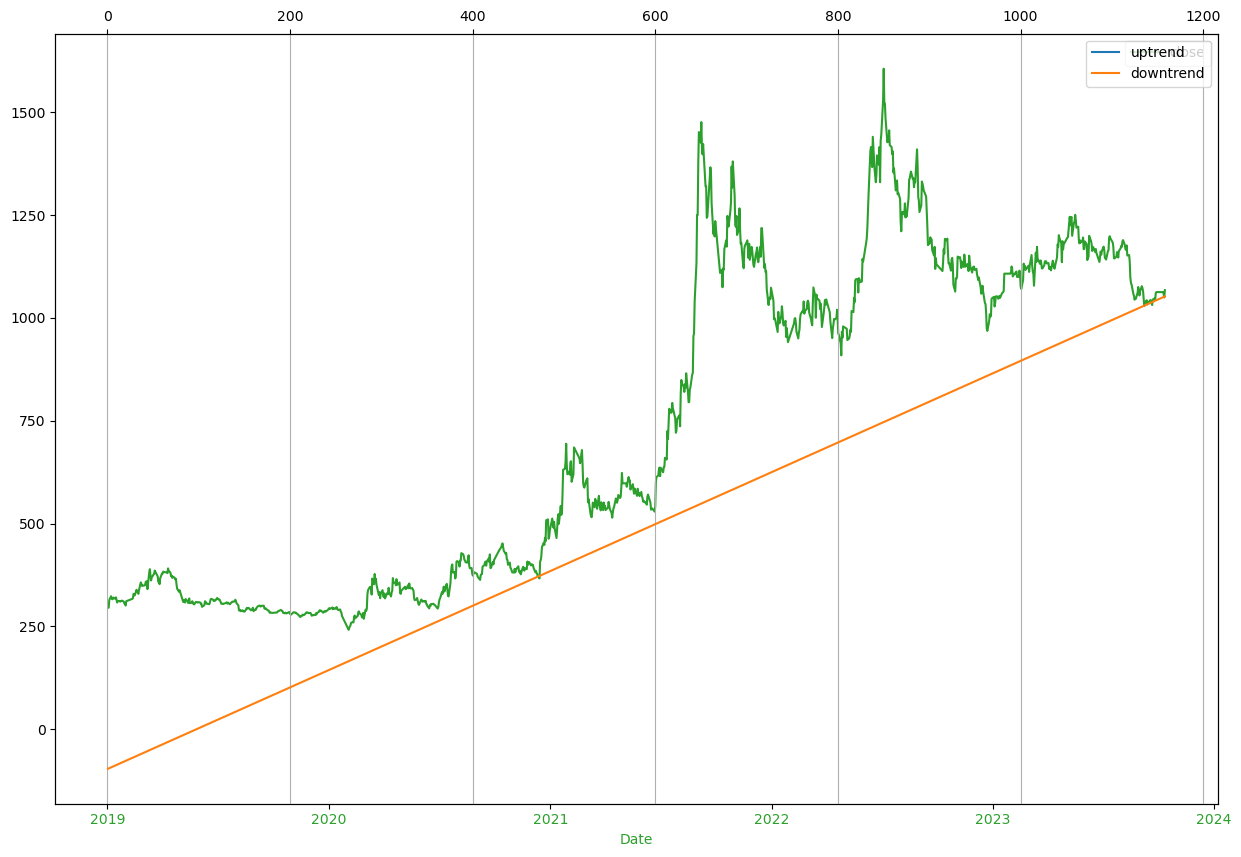

In [11]:
# draw the closing price and related trendlines (uptrend and downtrend)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15,10))

color = 'tab:green'
xdate = [x.date() for x in df.index]
ax1.set_xlabel('Date', color=color)
ax1.plot(xdate, df['收盘'], label="close", color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.legend()

ax2 = ax1.twiny() # ax2 and ax1 will have common y axis and different x axis, twiny
ax2.plot(df.Number, df.Uptrend, label="uptrend")
ax2.plot(df.Number, df.Downtrend, label="downtrend")

plt.legend()
plt.grid()
plt.show()

In [12]:
df_low

开盘       收盘       最高       最低     成交量          成交额    振幅  \
日期                                                                          
2020-12-11   378.75   372.44   380.33   359.83  755164  599023072.0  5.42   
2023-09-22  1027.83  1044.22  1044.90  1026.46  333033  480798320.0  1.79   

             涨跌幅    涨跌额   换手率     sma_200  Number  
日期                                                 
2020-12-11 -1.53  -5.78  2.03   360.96990     473  
2023-09-22  1.26  12.98  0.66  1122.82525    1150

In [13]:
df

开盘       收盘       最高       最低     成交量          成交额    振幅  \
日期                                                                          
2019-01-02   290.21   295.47   295.47   285.48  126355   85796723.0  3.46   
2019-01-03   291.79   295.47   295.99   290.21  179333  123583832.0  1.96   
2019-01-04   291.79   314.38   314.91   290.74  878087  628530464.0  8.18   
2019-01-07   315.96   323.32   327.52   313.33  956155  708704192.0  4.51   
2019-01-08   320.69   317.54   322.79   315.43  485427  357107472.0  2.28   
...             ...      ...      ...      ...     ...          ...   ...   
2023-09-28  1061.30  1062.66  1066.08  1057.88  267773  396546731.0  0.77   
2023-10-09  1061.30  1062.66  1065.39  1050.37  252380  372687175.0  1.41   
2023-10-10  1064.71  1057.88  1071.54  1057.88  214808  318486635.0  1.29   
2023-10-11  1059.25  1049.68  1067.44  1047.63  262149  385790841.0  1.87   
2023-10-12  1061.30  1067.44  1069.49  1053.10  300841  446414468.0  1.56   

             涨跌幅    涨跌额   换手率     sma_200  Number  Uptrend    Downtrend  
日期                                                                       
2019-01-02  2.37   6.83  0.34   311.13580       1      NaN   -95.920650  
2019-01-03  0.00   0.00  0.48   310.58935       2      NaN   -94.928360  
2019-01-04  6.40  18.91  2.36   310.15585       3      NaN   -93.936071  
2019-01-07  2.84   8.94  2.57   309.78020       4      NaN   -92.943781  
2019-01-08 -1.79  -5.78  1.31   309.38615       5      NaN   -91.951492  
...          ...    ...   ...         ...     ...      ...          ...  
2023-09-28  0.19   2.05  0.53  1121.56890    1154      NaN  1048.189158  
2023-10-09  0.00   0.00  0.50  1121.38655    1155      NaN  1049.181448  
2023-10-10 -0.45  -4.78  0.43  1121.21710    1156      NaN  1050.173737  
2023-10-11 -0.78  -8.20  0.52  1120.97510    1157      NaN  1051.166027  
2023-10-12  1.69  17.76  0.60  1120.94275    1158      NaN  1052.158316  

[1158 rows x 14 columns]

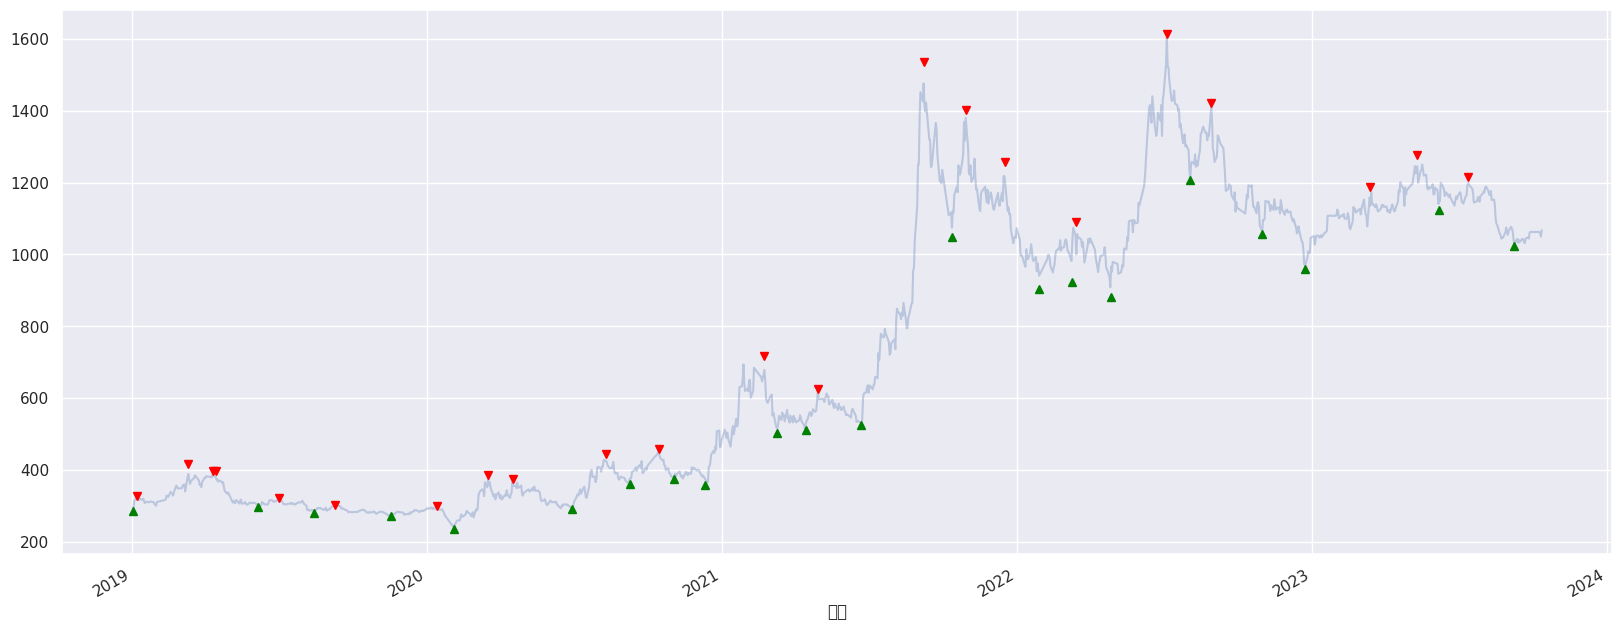

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# This makes plots prettier
import seaborn; seaborn.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import argrelextrema
import numpy as np
pd.options.plotting.backend = "matplotlib"

# sh300['date'] = sh300['date'].apply(pd.to_datetime)
# x = sh300[sh300['date'].isin(pd.date_range(start='2015-01-01', end='2023-03-23'))]
# x = x.set_index('date')

ilocs_min = argrelextrema(df['最低'].values, np.less_equal, order=20)[0]
ilocs_max = argrelextrema(df['最高'].values, np.greater_equal, order=20)[0]

df['收盘'].plot(figsize=(20,8), alpha=.3)
# filter prices that are peaks and plot them differently to be visable on the plot
df.iloc[ilocs_max]['最高'].plot(style='.', lw=10, color='red', marker="v");
df.iloc[ilocs_min]['最低'].plot(style='.', lw=10, color='green', marker="^");

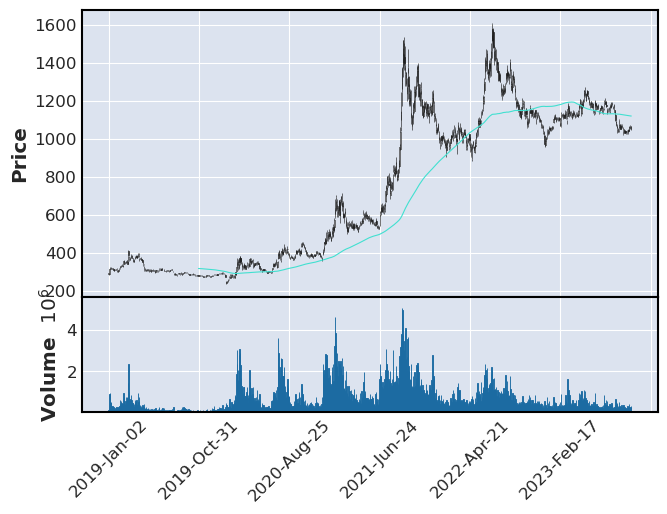

In [15]:
import mplfinance as mpf

df[['Open','High','Low','Close','Volume']] = df[['开盘','最高','最低','收盘','成交量']]

mpf.plot(df,type='candle',mav=200,volume=True)

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress


In [4]:
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')

In [5]:
yfinance = YFinance()
df = yfinance.query(['TSLA'], start_date='1/1/2012', end_date='12/16/2023')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df_len = len(df)
df['Number'] = np.arange(df_len)+1

Loaded cached bar data.



In [6]:
df['adj_factor'] = df['adj_close']/df['close']
df['adj_low'] = df['adj_factor']*df['low']
df['adj_high'] = df['adj_factor']*df['high']

In [203]:
ilocs_min[:-1]

array([  0,  49,  95, 179, 227, 278, 403, 433, 479, 503, 530, 636, 686,
       718, 797])

In [204]:
ilocs_min = argrelextrema(df.adj_low.values, np.less_equal, order=20)[0]
ilocs_max = argrelextrema(df.adj_high.values, np.greater_equal, order=20)[0]

# dfi = df[df['Number'] < len(df)*0.95]
df_low = df.iloc[ilocs_min]
df_max = df.iloc[ilocs_max]
# while len(df_low)>3:
#     slope, intercept, r_value, p_value, std_err = linregress(x=df_low['Number'], y=df_low.adj_low)
#     df_low = df_low.loc[df_low.adj_low < slope * df_low['Number'] + intercept]  

# slope, intercept, r_value, p_value, std_err = linregress(x=df_low['Number'], y=df_low.adj_low)
# df['Downtrend'] = slope * df['Number'] + intercept

In [205]:
df_low.iloc[argrelextrema(df_low.adj_low.values, np.less_equal, order=1)[0]]

symbol        open        high         low       close     volume  \
date                                                                           
2012-01-13   TSLA    1.893333    1.900000    1.509333    1.519333   82506000   
2012-08-02   TSLA    1.789333    1.790000    1.701333    1.740000   19576500   
2012-10-15   TSLA    1.868000    1.870000    1.790667    1.822000   22030500   
2015-03-27   TSLA   12.604667   12.619333   12.093333   12.333333  129073500   
2016-02-09   TSLA    9.488000   10.652667    9.403333    9.883333  129774000   
2016-06-27   TSLA   12.724000   13.254000   12.524667   13.236667  108081000   
2016-11-14   TSLA   12.533333   12.550000   11.879333   12.096667   98283000   
2017-11-02   TSLA   20.008667   20.579332   19.508667   19.950666  296871000   
2018-04-02   TSLA   17.084000   17.355333   16.306000   16.832001  241710000   
2018-10-10   TSLA   17.640667   17.700666   16.518000   17.125334  192229500   
2019-06-03   TSLA   12.367333   12.445333   11.799333   11.931333  195966000   
2023-01-06   TSLA  103.000000  114.389999  101.809998  113.059998  220911100   
2023-04-27   TSLA  152.639999  160.479996  152.369995  160.190002  127015200   
2023-10-31   TSLA  196.119995  202.800003  194.070007  200.839996  118068300   

             adj_close  Number  adj_factor     adj_low    adj_high  
date                                                                
2012-01-13    1.519333       9         1.0    1.509333    1.900000  
2012-08-02    1.740000     148         1.0    1.701333    1.790000  
2012-10-15    1.822000     199         1.0    1.790667    1.870000  
2015-03-27   12.333333     813         1.0   12.093333   12.619333  
2016-02-09    9.883333    1032         1.0    9.403333   10.652667  
2016-06-27   13.236667    1128         1.0   12.524667   13.254000  
2016-11-14   12.096667    1226         1.0   11.879333   12.550000  
2017-11-02   19.950666    1470         1.0   19.508667   20.579332  
2018-04-02   16.832001    1571         1.0   16.306000   17.355333  
2018-10-10   17.125334    1705         1.0   16.518000   17.700666  
2019-06-03   11.931333    1865         1.0   11.799333   12.445333  
2023-01-06  113.059998    2772         1.0  101.809998  114.389999  
2023-04-27  160.190002    2848         1.0  152.369995  160.479996  
2023-10-31  200.839996    2977         1.0  194.070007  202.800003

In [206]:
lowest = df_low.iloc[argrelextrema(df_low.adj_low.values, np.less_equal, order=1)[0]]#.nsmallest(2, 'adj_low')


while len(lowest)>2:
    slope, intercept, r_value, p_value, std_err = linregress(x=lowest['Number'], y=lowest.adj_low)
    lowest = lowest.loc[lowest.adj_low <= slope * lowest['Number'] + intercept]  

slope, intercept, r_value, p_value, std_err = linregress(x=lowest['Number'], y=lowest.adj_low)
df['Downtrend'] = slope * df['Number'] + intercept
df.loc[df['Downtrend'] < 0]['Downtrend'] = None


# slope, intercept, r_value, p_value, std_err = linregress(x=lowest['Number'], y=lowest.adj_low)


# df['Downtrend'] = slope * df['Number'] + intercept

/tmp/ipykernel_1225490/395175062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Downtrend'] < 0]['Downtrend'] = None


In [207]:
lowest

symbol       open       high        low      close     volume  \
date                                                                       
2018-04-02   TSLA  17.084000  17.355333  16.306000  16.832001  241710000   
2019-06-03   TSLA  12.367333  12.445333  11.799333  11.931333  195966000   

            adj_close  Number  adj_factor    adj_low   adj_high  
date                                                             
2018-04-02  16.832001    1571         1.0  16.306000  17.355333  
2019-06-03  11.931333    1865         1.0  11.799333  12.445333

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:887: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:887: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


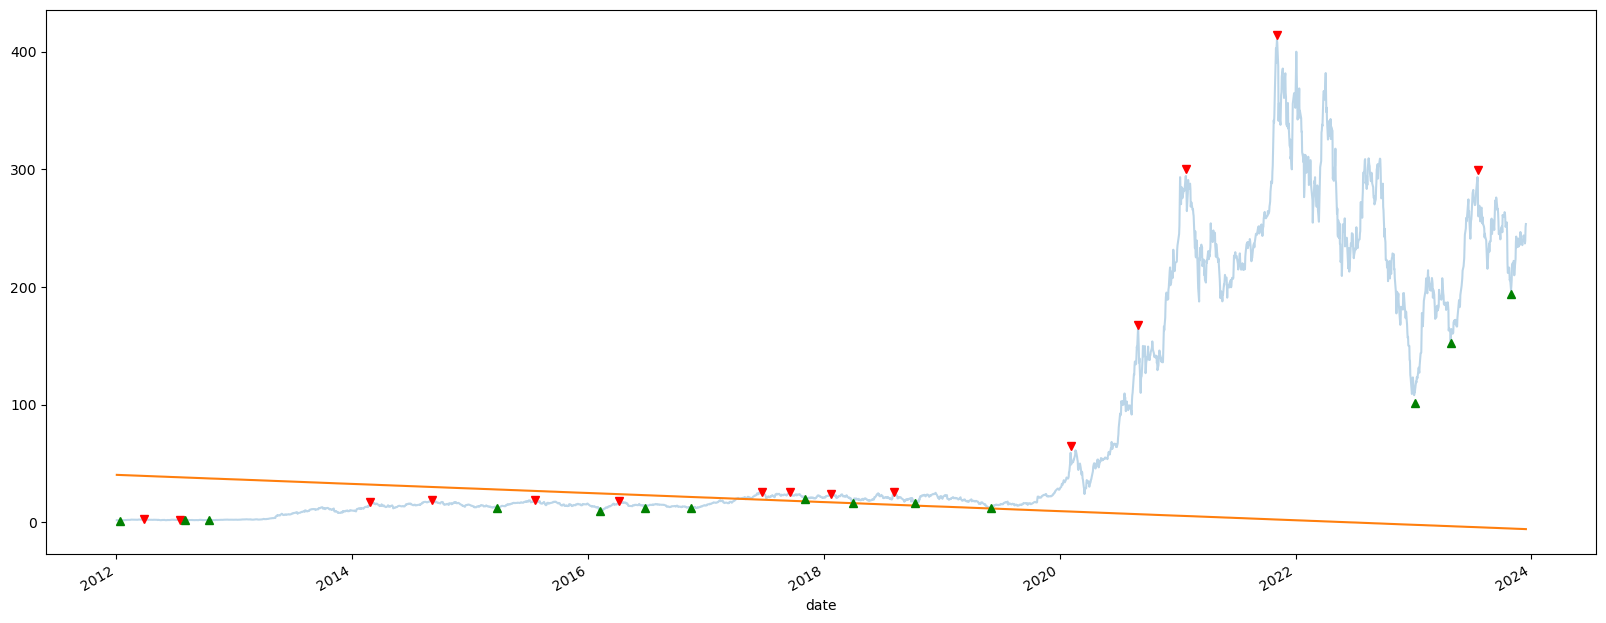

In [208]:

df.adj_close.plot(figsize=(20,8), alpha=.3)
# filter prices that are peaks and plot them differently to be visable on the plot
# df.iloc[ilocs_max].adj_high.plot(style='.', lw=10, color='red', marker="v");
# df.iloc[ilocs_min].adj_low.plot(style='.', lw=10, color='green', marker="^");
df.Downtrend.plot()

df_max.iloc[argrelextrema(df_max.adj_high.values, np.greater_equal, order=1)[0]].adj_high.plot(style='.', lw=10, color='red', marker="v");
df_low.iloc[argrelextrema(df_low.adj_low.values, np.less_equal, order=1)[0]].adj_low.plot(style='.', lw=10, color='green', marker="^");

In [140]:
pd.set_option('display.max_rows', None)
df

symbol       open       high        low      close   volume  \
date                                                                     
2012-01-02  AF.PA  20.163822  20.930429  20.123474  20.879995   356275   
2012-01-03  AF.PA  21.076691  21.076691  20.481562  20.784168   418939   
2012-01-04  AF.PA  20.779125  20.779125  20.178951  20.229387   385421   
2012-01-05  AF.PA  20.173908  20.214256  19.119822  19.215649   995011   
2012-01-06  AF.PA  19.387127  20.163822  19.316519  19.957039  1010078   
2012-01-09  AF.PA  20.123474  20.153734  19.190432  19.230778   726476   
2012-01-10  AF.PA  19.639299  19.957039  19.452690  19.629213   661416   
2012-01-11  AF.PA  19.740170  20.269735  19.669561  20.133560   688965   
2012-01-12  AF.PA  20.199125  21.636517  20.173908  21.636517  1336309   
2012-01-13  AF.PA  21.782778  22.342604  20.955648  21.404516  1846301   
2012-01-16  AF.PA  20.965734  22.166082  20.733734  22.085386   649485   
2012-01-17  AF.PA  22.322430  22.640169  21.954256  22.579647   793982   
2012-01-18  AF.PA  22.594778  23.260517  22.201387  23.003300   720861   
2012-01-19  AF.PA  23.129387  25.232515  22.846952  25.040865  1643908   
2012-01-20  AF.PA  25.071125  25.116516  24.309561  24.924864   749278   
2012-01-23  AF.PA  25.166950  25.772167  24.965212  25.519995   767678   
2012-01-24  AF.PA  25.489735  25.494778  24.334778  24.576864   734094   
2012-01-25  AF.PA  24.823996  25.116516  23.658951  24.813908  1089815   
2012-01-26  AF.PA  25.106428  25.973907  24.768517  25.671299   767560   
2012-01-27  AF.PA  25.373734  26.170603  25.116516  25.328342   782015   
2012-01-30  AF.PA  25.116516  25.303125  24.127995  24.415474   510561   
2012-01-31  AF.PA  24.637386  25.217386  24.324690  24.460863   590521   
2012-02-01  AF.PA  24.642429  25.651125  24.561733  25.519995   774599   
2012-02-02  AF.PA  25.711647  26.765734  25.182081  26.367298   791850   
2012-02-03  AF.PA  26.367298  27.022951  26.125212  26.937212   726120   
2012-02-06  AF.PA  26.730429  26.730429  25.635996  25.822603   889724   
2012-02-07  AF.PA  25.630951  25.772167  24.894604  25.772167   852711   
2012-02-08  AF.PA  25.772167  25.923473  25.368690  25.504864   605990   
2012-02-09  AF.PA  25.646082  26.160517  25.368690  25.605734   680521   
2012-02-10  AF.PA  25.368690  25.459473  24.511299  24.576864   665000   
2012-02-13  AF.PA  24.965212  25.076168  24.365038  24.536516   491617   
2012-02-14  AF.PA  24.460863  24.748343  23.406778  23.613560   812576   
2012-02-15  AF.PA  23.926256  24.965212  23.724518  23.901037   808550   
2012-02-16  AF.PA  23.704344  23.845560  22.806604  23.295820   826953   
2012-02-17  AF.PA  23.774952  24.359995  23.517735  24.102777   784635   
2012-02-20  AF.PA  24.359995  24.642429  24.107821  24.370083   483971   
2012-02-21  AF.PA  24.435646  24.486082  23.477386  23.734604   687359   
2012-02-22  AF.PA  23.946430  24.057386  23.003300  23.038605   880214   
2012-02-23  AF.PA  23.179821  23.179821  21.813040  22.796516  1349204   
2012-02-24  AF.PA  22.957909  23.043648  22.443474  22.514082   684590   
2012-02-27  AF.PA  22.387995  22.387995  21.434778  21.949213  1120880   
2012-02-28  AF.PA  22.181213  22.292170  21.853388  22.140865   696489   
2012-02-29  AF.PA  22.196342  22.993212  22.196342  22.377909   734550   
2012-03-01  AF.PA  22.680517  22.912518  21.727301  22.246778   809961   
2012-03-02  AF.PA  22.216516  22.741039  21.969387  22.529213   565781   
2012-03-05  AF.PA  22.488865  22.645212  21.772692  21.818083   780789   
2012-03-06  AF.PA  21.797909  21.802952  20.779125  20.779125   861190   
2012-03-07  AF.PA  20.683300  21.303648  20.491648  21.106953   626365   
2012-03-08  AF.PA  20.930429  21.792866  20.486605  21.051474  1229216   
2012-03-09  AF.PA  21.046431  21.419647  20.900169  20.900169   648474   
2012-03-12  AF.PA  20.930429  21.308691  20.824516  20.950603   588655   
2012-03-13  AF.PA  21.081736  22.226604  21.056517  22.019821  1174509   
2012-03-14  AF.

                         QuantReg Regression Results                          
Dep. Variable:                adj_low   Pseudo R-squared:            1.417e-05
Model:                       QuantReg   Bandwidth:                      0.6938
Method:                 Least Squares   Sparsity:                        1.970
Date:                Mon, 18 Dec 2023   No. Observations:                   76
Time:                        14:05:47   Df Residuals:                       74
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4170      0.224      6.316      0.000       0.970       1.864
Number      6.278e-07      0.000      0.005      0.996      -0.000       0.000

The condition number is large, 3.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


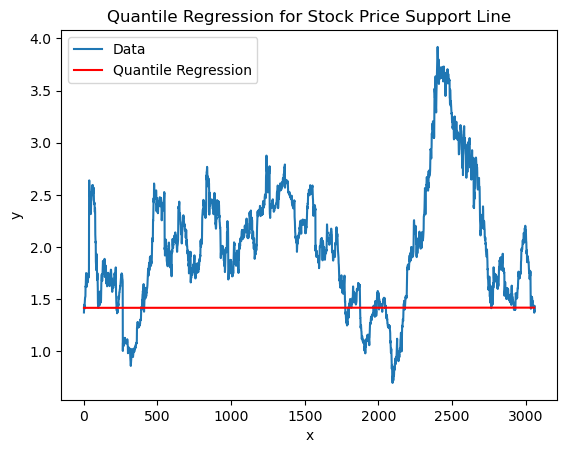

In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 生成示例数据
# np.random.seed(42)
# data_size = 100
# x = np.random.rand(data_size, 1)  # 自变量
# y = 3 * x + np.random.randn(data_size, 1)  # 因变量

# # 合并数据到DataFrame
# df = pd.DataFrame({'x': x.flatten(), 'y': y.flatten()})

# 定义分位数，例如0.25表示第25%的分位数，即股价的下限
quantiles = [0.25, 0.5, 0.75]

# 执行分位数回归
quant_reg = sm.QuantReg(df_low['adj_low'], sm.add_constant(df_low['Number']))
results = quant_reg.fit(q=0.25)

# 打印回归结果
print(results.summary())

# 提取回归系数
coefficients = results.params

# 打印支撑线的回归方程
for i, quantile in enumerate(quantiles):
    print(f'Quantile {quantile}: y = {coefficients[0]:.4f} + {coefficients[1]:.4f} * x')

# 绘制散点图和支撑线
import matplotlib.pyplot as plt

plt.plot(df['Number'], df['adj_low'], label='Data')
plt.plot(df_low['Number'], results.predict(), color='red', label='Quantile Regression')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quantile Regression for Stock Price Support Line')
plt.show()


In [265]:
results.predict()

array([1.42870235, 1.41993222, 1.41534783, 1.41076344, 1.40817227,
       1.40159467, 1.39800689, 1.37508495, 1.37050057])

In [220]:
df_low['Number']

date
2022-10-21     15
2023-05-31    169
2023-12-11    307
Name: Number, dtype: int64

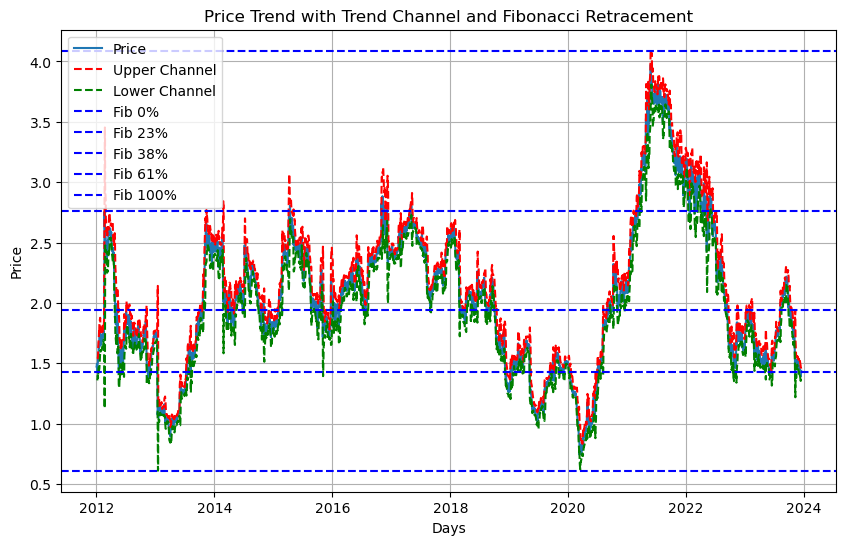

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # 生成示例数据
# np.random.seed(42)
# price_data = np.cumsum(np.random.normal(0, 1, 100))  # 随机生成价格序列

# # 转换为 Pandas DataFrame
# df = pd.DataFrame({'Price': price_data})

# 计算趋势通道
window_size = 5
df['Upper Channel'] = df['adj_high'].rolling(window=window_size).mean() + 2 * df['adj_high'].rolling(window=window_size).std()
df['Lower Channel'] = df['adj_low'].rolling(window=window_size).mean() - 2 * df['adj_low'].rolling(window=window_size).std()

# 计算斐波那契 retracement 水平
low_point = df['Lower Channel'].min()
high_point = df['Upper Channel'].max()
fibonacci_levels = [0, 0.236, 0.382, 0.618, 1]

fibonacci_values = [low_point + level * (high_point - low_point) for level in fibonacci_levels]

# 绘制价格走势图
plt.figure(figsize=(10, 6))
plt.plot(df['adj_close'], label='Price')

# 绘制趋势通道
plt.plot(df['Upper Channel'], linestyle='--', color='red', label='Upper Channel')
plt.plot(df['Lower Channel'], linestyle='--', color='green', label='Lower Channel')

# 绘制斐波那契 retracement 水平
for level, value in zip(fibonacci_levels, fibonacci_values):
    plt.axhline(value, linestyle='--', color='blue', label=f'Fib {int(level * 100)}%')

plt.title('Price Trend with Trend Channel and Fibonacci Retracement')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [92]:
df

symbol    open    high     low   close    volume  adj_close  \
date                                                                      
2022-01-03  PNL.AS  3.8490  3.8900  3.8330  3.8600   1932483   3.174222   
2022-01-04  PNL.AS  3.8860  3.8990  3.8020  3.8480   2687612   3.164353   
2022-01-05  PNL.AS  3.8500  3.8880  3.8260  3.8830   2718315   3.193135   
2022-01-06  PNL.AS  3.8360  3.8650  3.7910  3.8210   2682504   3.142150   
2022-01-07  PNL.AS  3.8380  3.8420  3.7860  3.8000   2201790   3.124881   
2022-01-10  PNL.AS  3.8190  3.8210  3.6760  3.6830   4510037   3.028668   
2022-01-11  PNL.AS  3.7050  3.7410  3.6850  3.7140   2538407   3.054160   
2022-01-12  PNL.AS  3.7200  3.7710  3.7050  3.7460   2219563   3.080475   
2022-01-13  PNL.AS  3.6450  3.6450  3.5040  3.5490  13078145   2.918475   
2022-01-14  PNL.AS  3.5290  3.5580  3.4600  3.4670   7445109   2.851043   
2022-01-17  PNL.AS  3.4860  3.5490  3.3550  3.5160   6025806   2.891338   
2022-01-18  PNL.AS  3.5000  3.5070  3.4500  3.4610   2832764   2.846109   
2022-01-19  PNL.AS  3.4600  3.4750  3.4210  3.4520   3202441   2.838708   
2022-01-20  PNL.AS  3.4730  3.4740  3.4340  3.4510   1711727   2.837885   
2022-01-21  PNL.AS  3.4130  3.4540  3.3960  3.4490   4886396   2.836241   
2022-01-24  PNL.AS  3.4300  3.4520  3.2710  3.3210   7673812   2.730982   
2022-01-25  PNL.AS  3.4370  3.5690  3.3990  3.5610  12769846   2.928343   
2022-01-26  PNL.AS  3.5800  3.6270  3.4940  3.5790   7867765   2.943145   
2022-01-27  PNL.AS  3.5330  3.6940  3.5260  3.6830   5702742   3.028668   
2022-01-28  PNL.AS  3.6850  3.7930  3.6690  3.7130   4815449   3.053338   
2022-01-31  PNL.AS  3.7610  3.8280  3.7430  3.7950   5343774   3.120770   
2022-02-01  PNL.AS  3.8220  3.8340  3.7470  3.7730   4017825   3.102678   
2022-02-02  PNL.AS  3.7930  3.8700  3.7930  3.8490   4087420   3.165175   
2022-02-03  PNL.AS  3.8450  3.8990  3.8420  3.8420   4280084   3.159420   
2022-02-04  PNL.AS  3.8420  3.8750  3.6780  3.6820   5225702   3.027845   
2022-02-07  PNL.AS  3.7000  3.7380  3.6300  3.6540   2996485   3.004820   
2022-02-08  PNL.AS  3.6540  3.7060  3.6530  3.6890   2536651   3.033602   
2022-02-09  PNL.AS  3.7010  3.7650  3.7010  3.7510   2550710   3.084587   
2022-02-10  PNL.AS  3.7600  3.7710  3.7050  3.7190   2364570   3.058272   
2022-02-11  PNL.AS  3.6960  3.7100  3.6670  3.7040   1889196   3.045937   
2022-02-14  PNL.AS  3.6500  3.6680  3.5880  3.6440   3304610   2.996597   
2022-02-15  PNL.AS  3.6450  3.6970  3.6340  3.6860   2002424   3.031135   
2022-02-16  PNL.AS  3.7020  3.7250  3.6210  3.6410   3003138   2.994130   
2022-02-17  PNL.AS  3.6400  3.6630  3.5750  3.5800   3076161   2.943967   
2022-02-18  PNL.AS  3.5770  3.6450  3.5350  3.6260   4285819   2.981795   
2022-02-21  PNL.AS  3.6190  3.6340  3.5050  3.5050   2854005   2.882292   
2022-02-22  PNL.AS  3.4300  3.4880  3.3680  3.4150   4491876   2.808281   
2022-02-23  PNL.AS  3.4320  3.4980  3.3880  3.3890   3108375   2.786901   
2022-02-24  PNL.AS  3.2950  3.3640  3.2400  3.3320   5517165   2.740028   
2022-02-25  PNL.AS  3.3700  3.4660  3.3290  3.4540   5142778   2.840353   
2022-02-28  PNL.AS  3.3990  3.5970  3.3200  3.5780   6786044   2.942322   
2022-03-01  PNL.AS  3.5910  3.7080  3.5910  3.6280   6032860   2.983439   
2022-03-02  PNL.AS  3.6040  3.6370  3.5560  3.5670   3599111   2.933277   
2022-03-03  PNL.AS  3.5830  3.7410  3.5800  3.6960   5996252   3.039358   
2022-03-04  PNL.AS  3.6790  3.7250  3.5700  3.5760   5966232   2.940678   
2022-03-07  PNL.AS  3.5000  3.5000  3.3070  3.3730   8060941   2.773743   
2022-03-08  PNL.AS  3.3800  3.5220  3.3790  3.4590   4954000   2.844464   
2022-03-09  PNL.AS  3.5360  3.6200  3.5000  3.6200   5330469   2.976861   
2022-03-10  PNL.AS  3.6600  3.7030  3.5400  3.5550   4194289   2.923409   
2022-03-11  PNL.AS  3.5950  3.5950  3.4720  3.5250   4502236   2.898739   
2022-03-14  PNL.AS  3.5620  3.6620  3.5400  3.6100   4123003   2.968637   
2022-03-15  PNL.AS  3.5810  3.6110  3

In [93]:
fibonacci_values

[1.2181863423740869,
 1.7060028130818607,
 2.0077875788587036,
 2.4956040495664773,
 3.2852052860510943]

/tmp/ipykernel_1242634/575918218.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend_Range'][data['adj_close'] < data['Trend']] = -1  # 趋势下跌
/tmp/ipykernel_1242634/575918218.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend_Range'][data['adj_close'] > data['Trend']] = 1   # 趋势上升
/tmp/ipykernel_1242634/575918218.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Trend_Change'] == -2] = 

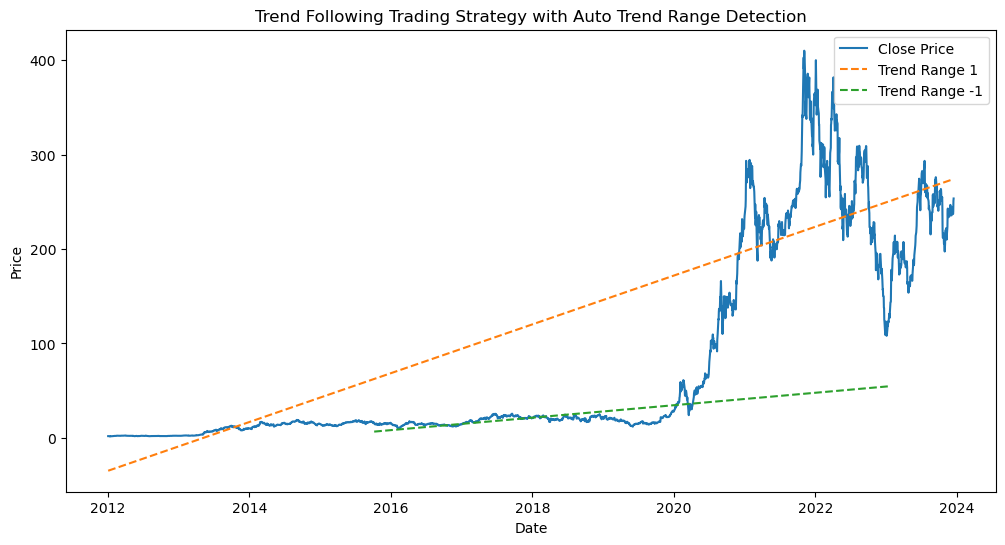

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def generate_trend_signals(data, window):
    # 计算历史最低价的波谷
    data['Trough'] = data['adj_low'].rolling(window=window, min_periods=1).min()

    # 通过线性回归计算波谷之间的连线
    x = np.arange(len(data)).reshape(-1, 1)
    y = data['Trough'].values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    data['Trend'] = model.predict(x)

    # 自动识别趋势区间
    data['Trend_Range'] = 0
    data['Trend_Range'][data['adj_close'] < data['Trend']] = -1  # 趋势下跌
    data['Trend_Range'][data['adj_close'] > data['Trend']] = 1   # 趋势上升

    # 识别趋势变化点
    data['Trend_Change'] = data['Trend_Range'].diff()

    # 为每个趋势区间计算直线趋势线
    trend_lines = {}
    for trend in data['Trend_Range'].unique():
        subset = data[data['Trend_Range'] == trend]
        model = LinearRegression().fit(subset.index.values.reshape(-1, 1), subset['adj_close'].values.reshape(-1, 1))
        trend_lines[trend] = model.predict(subset.index.values.astype(np.int64).reshape(-1, 1))

    # 生成趋势信号
    data['Signal'] = 0
    data['Signal'][data['Trend_Change'] == -2] = -1  # 卖出信号
    data['Signal'][data['Trend_Change'] == 2] = 1   # 买入信号

    # 生成持仓信号
    data['Position'] = data['Signal'].diff()

    return trend_lines

def plot_signals(data, trend_lines):
    plt.figure(figsize=(12, 6))
    plt.plot(data['adj_close'], label='Close Price')

    # 标记买卖信号
#     plt.plot(data[data['Signal'] == 1].index, data['adj_close'][data['Signal'] == 1], '^', markersize=10, color='g', label='Buy Signal')
#     plt.plot(data[data['Signal'] == -1].index, data['adj_close'][data['Signal'] == -1], 'v', markersize=10, color='r', label='Sell Signal')

    # 绘制趋势区间和直线趋势线
    for trend, line in trend_lines.items():
        plt.plot(data[data['Trend_Range'] == trend].index, line, label=f'Trend Range {trend}', linestyle='--')

    plt.title('Trend Following Trading Strategy with Auto Trend Range Detection')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 示例数据
data = df

# 参数设置
window = 130

# 生成趋势信号和直线趋势线
trend_lines = generate_trend_signals(data, window)

# 绘制交易信号图
plot_signals(data, trend_lines)


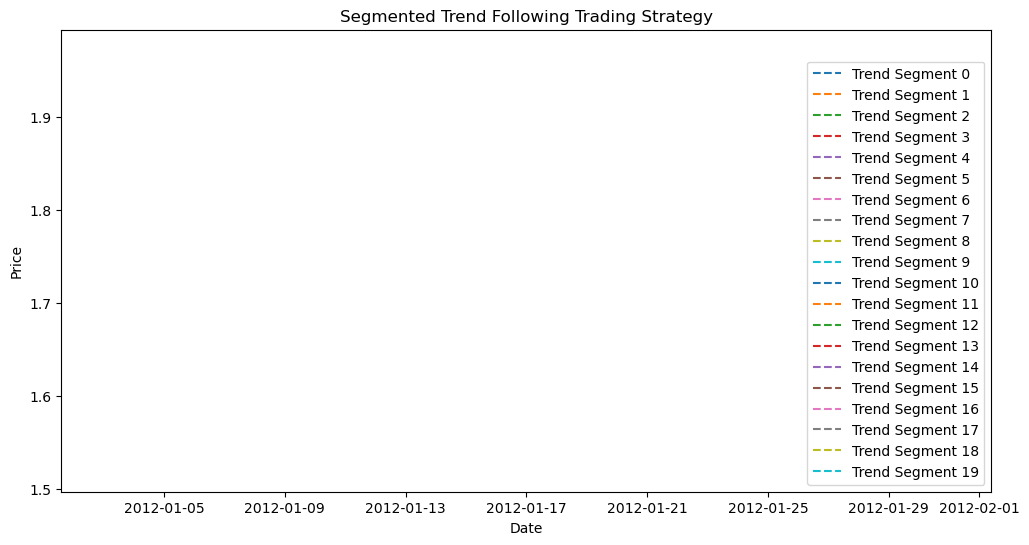

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ruptures import Pelt
from sklearn.linear_model import LinearRegression

def generate_trend_signals(data):
   # 使用 Pelt 找到拐点
    model = Pelt(model="rbf", min_size=3).fit(data['adj_low'].values)
    result = model.predict(pen=10)

    # 根据拐点划分分段线性回归
    breakpoints = np.where(np.diff(result))[0] + 1
    trend_lines = {}

    for i in range(len(breakpoints)):
        start = breakpoints[i - 1] if i > 0 else 0
        end = breakpoints[i]

        subset = data.iloc[start:end]
        # 自定义线性回归
        X = np.array(subset.index).astype(np.int64).reshape(-1, 1)
        y = subset['adj_close'].values.reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        trend_lines[i] = model.predict(X)

    return trend_lines, breakpoints

def plot_signals(data, trend_lines, breakpoints):
    plt.figure(figsize=(12, 6))
#     plt.plot(data['adj_close'], label='Close Price')

    # 绘制分段趋势线
    for i, line in trend_lines.items():
        start = breakpoints[i - 1] if i > 0 else 0
        end = breakpoints[i]
        plt.plot(data.iloc[start:end].index, label=f'Trend Segment {i}', linestyle='--')

    plt.title('Segmented Trend Following Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 示例数据
data = df

# 生成分段趋势线
trend_lines, breakpoints = generate_trend_signals(data)

# 绘制分段趋势线图
plot_signals(data, trend_lines, breakpoints)


TypeError: float() argument must be a string or a real number, not 'builtin_function_or_method'

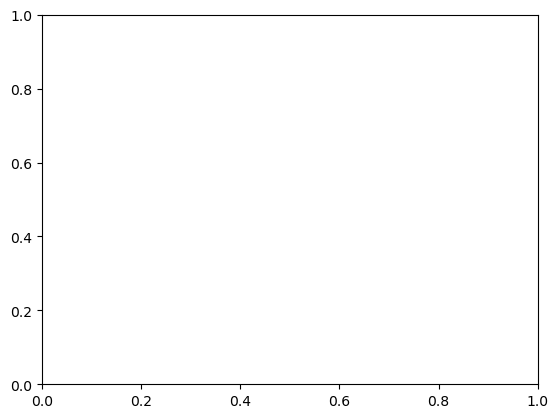

In [48]:


plt.plot(data.iloc[1:2].index,label=f'Trend Segment {1}', linestyle='--')


In [25]:
import ruptures

In [26]:
help(ruptures)

Help on package ruptures:

NAME
    ruptures - Offline change point detection for Python.

PACKAGE CONTENTS
    base
    costs (package)
    datasets (package)
    detection (package)
    exceptions
    metrics (package)
    show (package)
    utils (package)
    version

VERSION
    1.1.9

FILE
    /home/ubuntu/anaconda3/lib/python3.11/site-packages/ruptures/__init__.py




(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

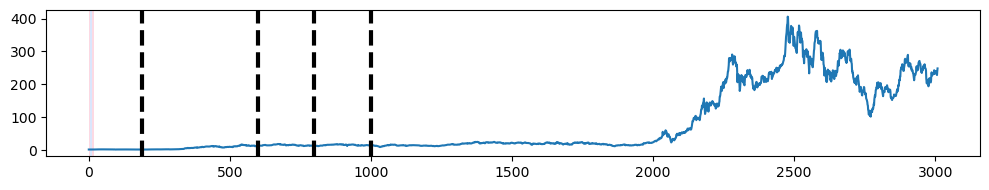

In [49]:
ruptures.display(data['adj_low'].values, breakpoints, result)
